# Uncertainty and sensitivity analyses

Using the Sensitivity Analysis Library [SALib](https://salib.readthedocs.io/en/latest/) in Python.

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From AeroMetric
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

In [2]:
def climate_metric_parametric(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    """
    Function to calculate climate metrics for aviation emissions using different climate models and methods.
    :return: 
    """
    
    ### Fixed parameters
    #time_horizon = 100 # years
    species = "Aviation contrails"
    unit_value = 1*10**10  # for contrails
    
    climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
    co2_method = 'FaIR' # IPCC or FaIR
    profile = "pulse"
    if climate_model == "FaIR":
        start_year = 1765
    else:
        start_year = 2000
    t0 = 2020
    if climate_model == "GWP*" or climate_model == "LWE":
        tcre = 0.00045
    end_year = t0 + time_horizon
    sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
    ratio_erf_rf_co2 = 1
    efficacy_erf_co2 = 1
    unit_value_co2 = 1*10**10
    
    ### Metric calculation
    if climate_model == "FaIR" or co2_method == "FaIR":
        background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
    
    # CO2 metrics (absolute)
    emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_value_co2)
    if co2_method == 'IPCC':
        agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
    elif co2_method == 'FaIR':
        species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
        model_settings_co2 = {"background_species_quantities": background_species_quantities}
        radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
        radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
        agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        
    # Species metrics (absolute)
    emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_value)
    if climate_model == "GWP*":
        species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"tcre": tcre}
        radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    elif climate_model == "LWE":
        species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"tcre": tcre}
        radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    elif climate_model == "FaIR":
        species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"background_species_quantities": background_species_quantities}
        radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
    
    # Species metrics (relative)
    gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)

    return gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr

In [3]:
# Single evaluation (test)
climate_metric_parametric(time_horizon=100, sensitivity_rf=2.23e-12, ratio_erf_rf=0.42, efficacy_erf=1.0)

(np.float64(25.465059576239167),
 np.float64(10.695325022020448),
 np.float64(10.695325022020448),
 np.float64(10.695325022020448),
 1.638873323631202,
 np.float64(12.085376639677422),
 np.float64(12.085376639677422))

In [4]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        #[6.7e-13, 3.8e-12], 
        [2.23e-12, 7.96e-13],
        #[0.31, 0.59], 
        [0.23, 0.87], 
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
    "outputs": ["gwp_rf", "gwp_erf", "egwp_rf", "egwp_erf", "gtp", "igtp", "ratr"],
})

# Create samples
sp.sample_sobol(1024, calc_second_order=False)

# Create wrapper for function
time_horizon=100
def wrapped_func(X):
    return np.array([climate_metric_parametric(time_horizon, *row) for row in X])

# Run simulations
sp.evaluate(wrapped_func);

# Calculate sobol indices
sp.analyze_sobol(print_to_console=False, calc_second_order=False);

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with 

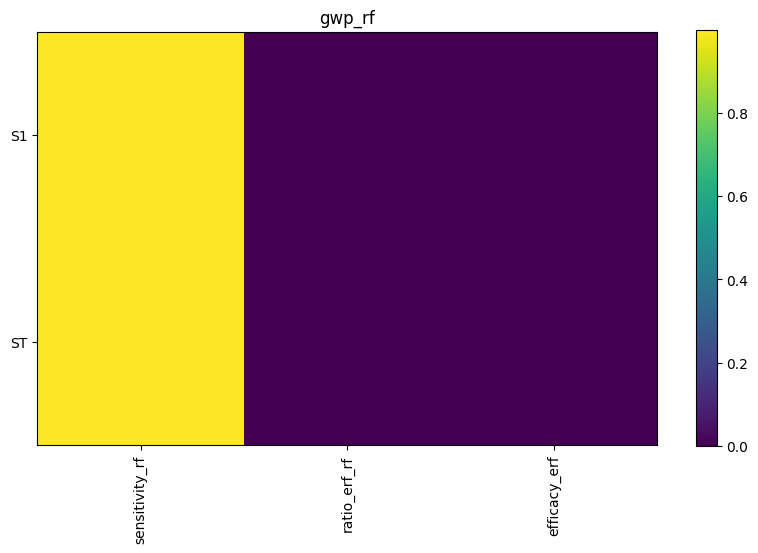

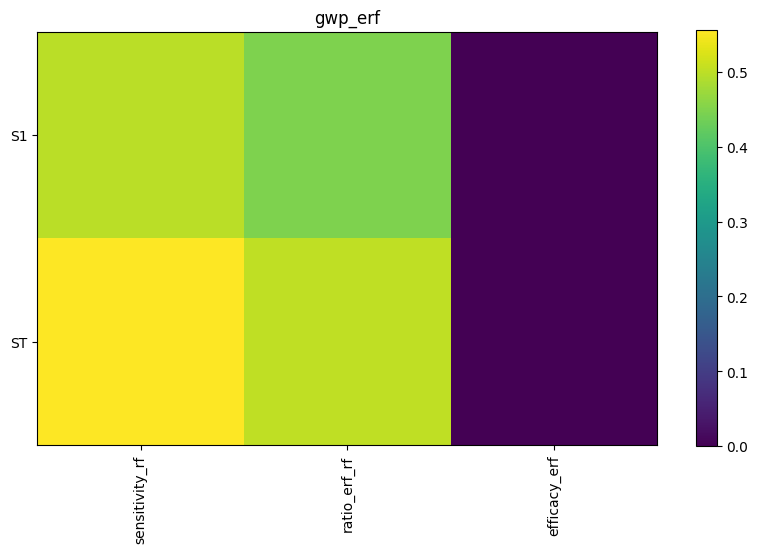

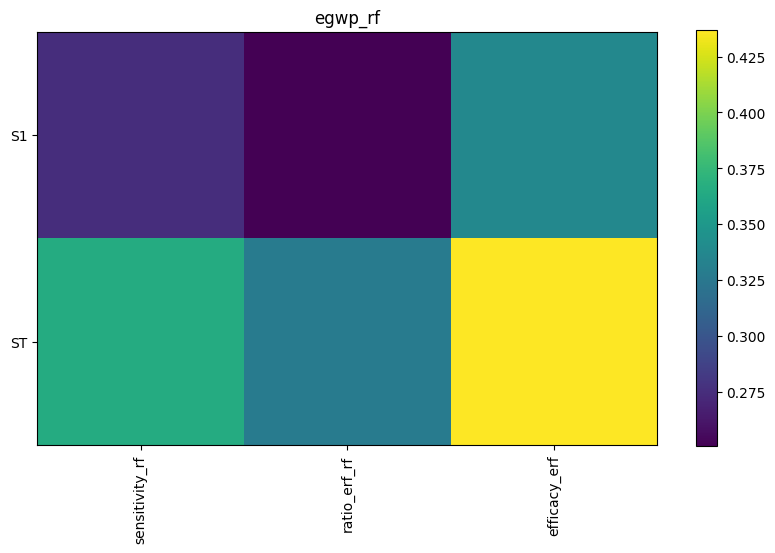

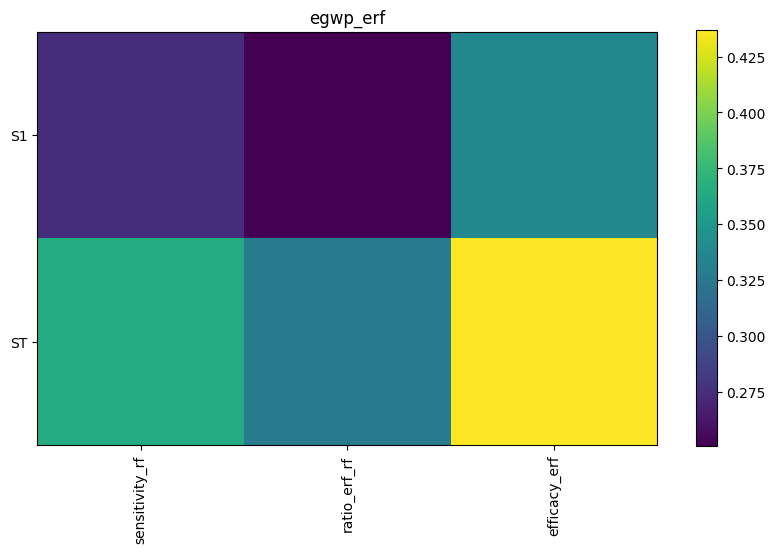

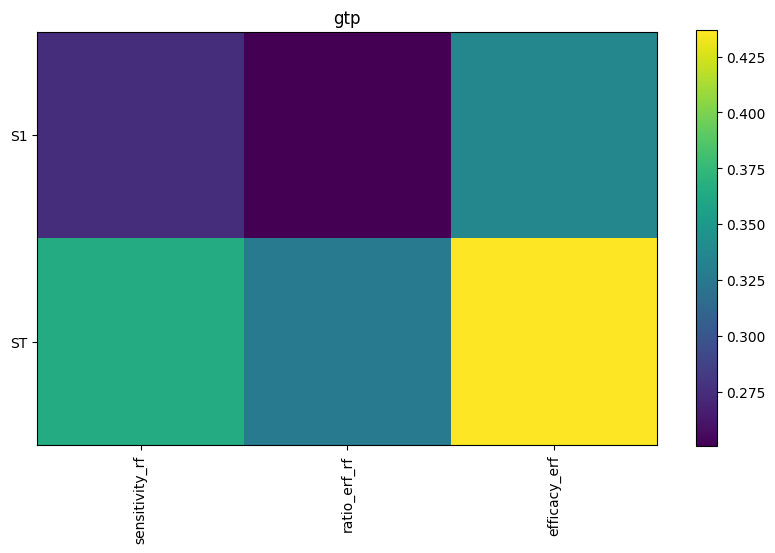

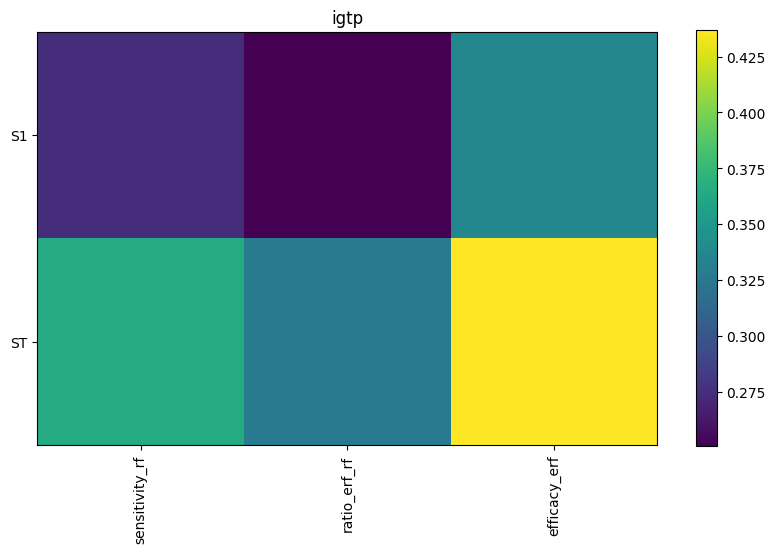

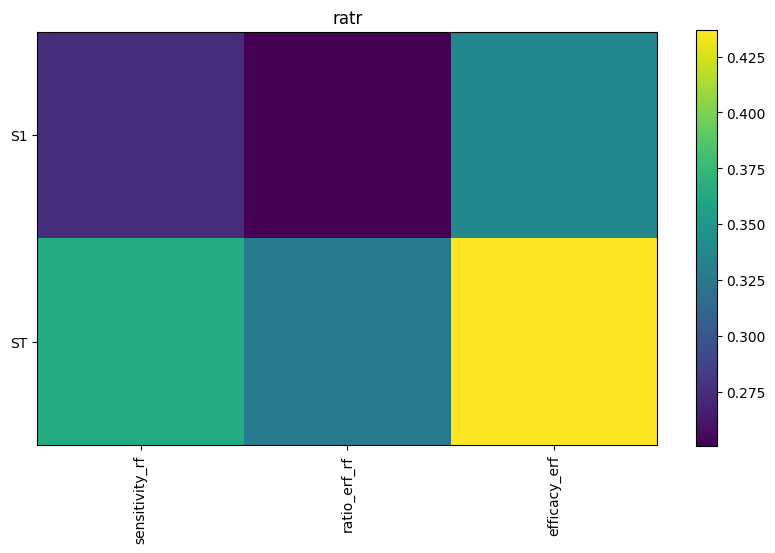

In [5]:
# Plot heatmaps
for output in sp["outputs"]:
    sp.heatmap(output)

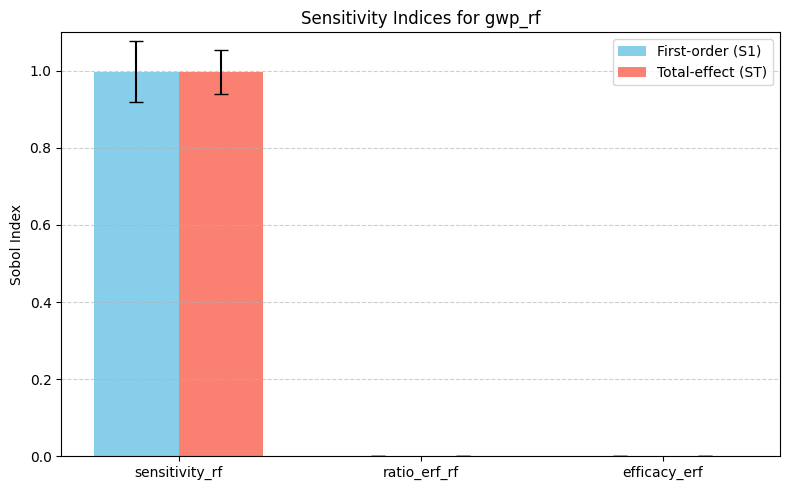

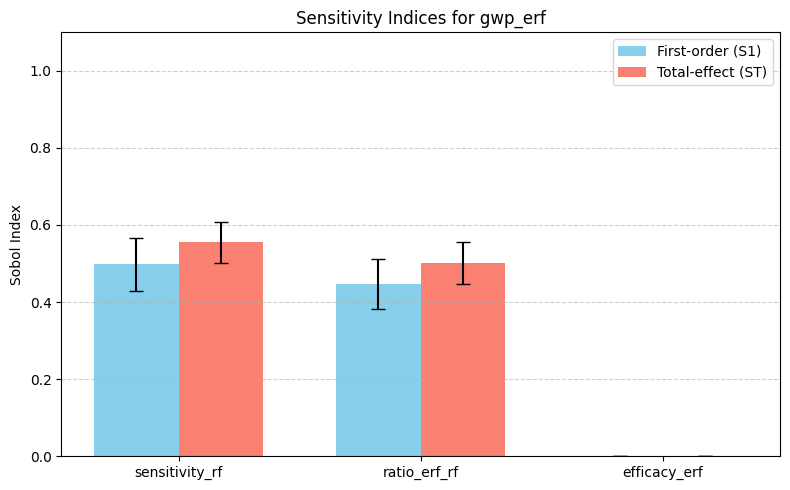

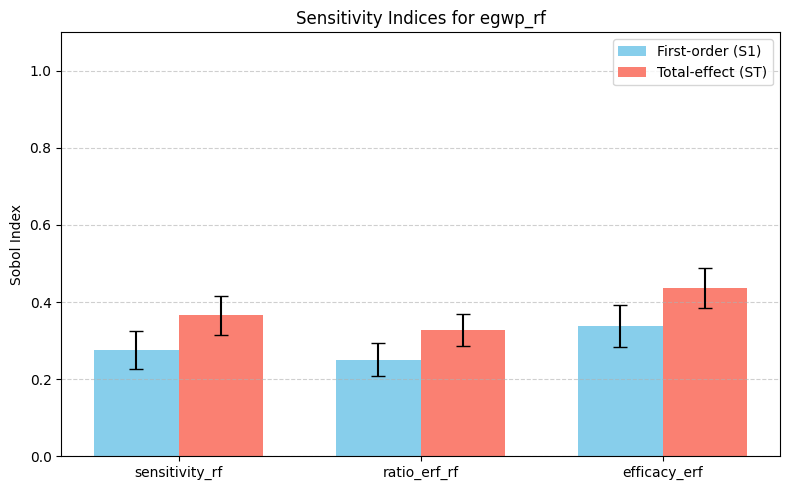

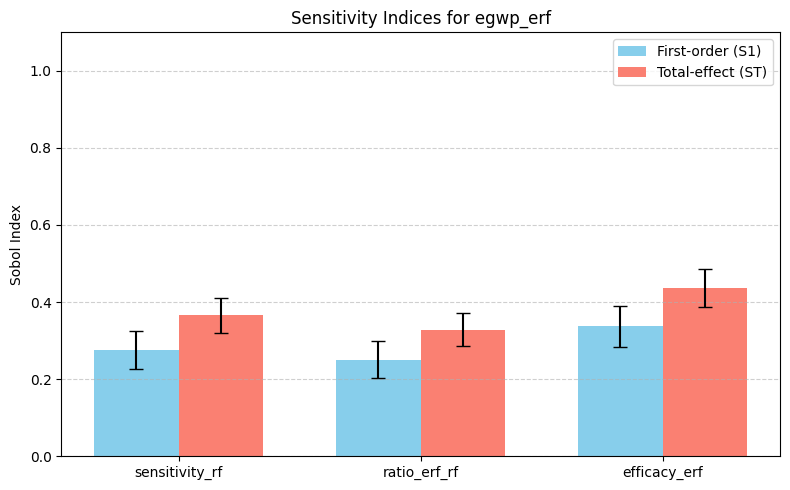

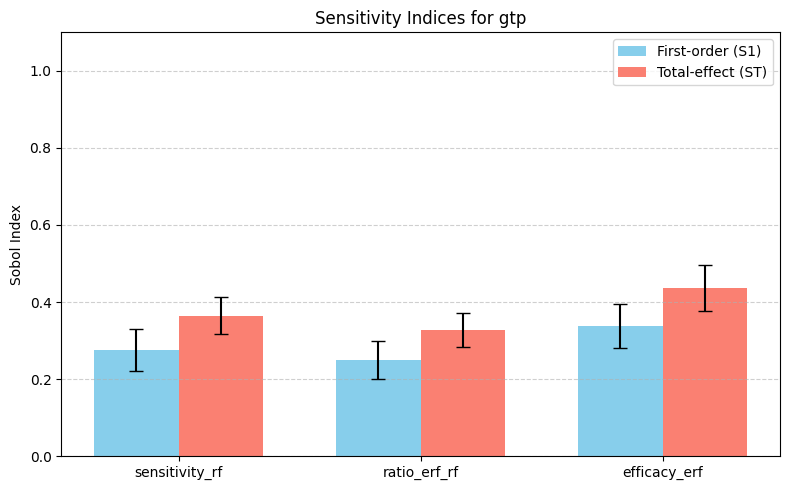

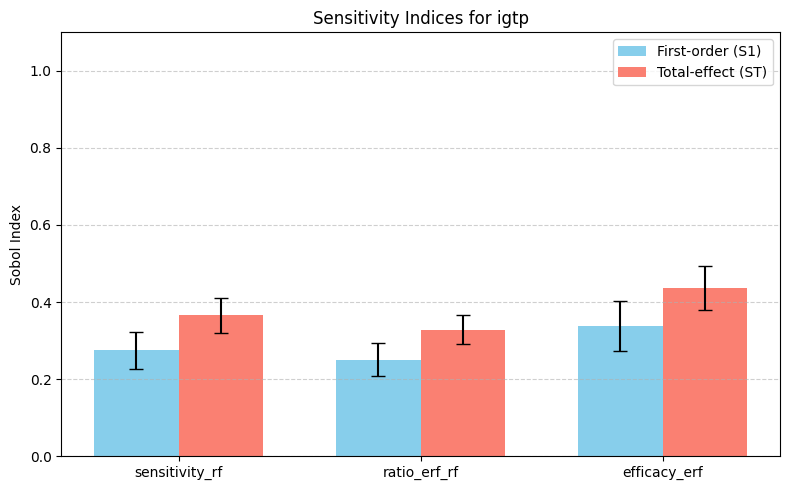

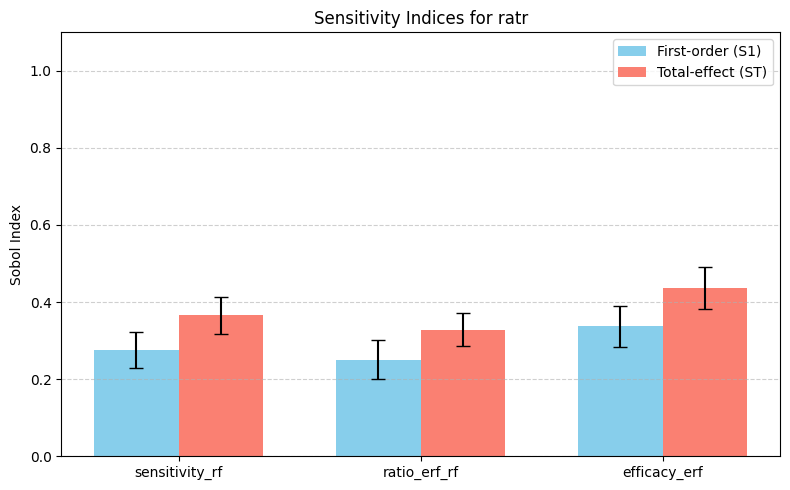

In [6]:
# Plot bars
names = sp["names"]
outputs = sp["outputs"]
analysis = sp.analysis

for i, output in enumerate(outputs):
    S1 = analysis[output]["S1"]
    S1_conf = analysis[output]["S1_conf"]
    ST = analysis[output]["ST"]
    ST_conf = analysis[output]["ST_conf"]

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(x - width/2, S1, width, yerr=S1_conf, capsize=5, label='First-order (S1)', color='skyblue')
    ax.bar(x + width/2, ST, width, yerr=ST_conf, capsize=5, label='Total-effect (ST)', color='salmon')

    ax.set_ylabel('Sobol Index')
    ax.set_title(f"Sensitivity Indices for {output}")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim(0, 1.1)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [7]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.23e-12, 7.96e-13],
        [0.23, 0.87],
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
    "outputs": ["gwp_rf", "gwp_erf", "egwp_rf", "egwp_erf", "gtp", "igtp", "ratr"],
})

# Sample with Morris
sp.sample_morris(N=50, num_levels=4)

# Define wrapped function
time_horizon = 100
def wrapped_func(X):
    return np.array([climate_metric_parametric(time_horizon, *row) for row in X])

# Evaluate model
sp.evaluate(wrapped_func)

# Analyze Morris
sp.analyze_morris(print_to_console=True)

C:\Users\t.planes\PycharmProjects\AeroMetrics\climate_models\fair_climate_model.py:419: RuntimeWarning: invalid value encountered in multiply
  rf = sensitivity_rf * species_quantities


ValueError: Aviation contrails contains NaN values in its forcing array, which you are trying to drive the simulation with.

In [ ]:
help(sp.sample_morris)